In [1]:
#a bunch of miscelanious libraries I imported...
#we can reduce this by a lot 

import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import json
import glob
import os
from sklearn.model_selection import cross_val_score
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

pd.set_option("display.max_rows", 101)
plt.rcParams['figure.dpi'] = 300

In [2]:
df = pd.read_csv('train_data.csv')

In [3]:
df

,date_hour,area_name,date_accident,hour_time,no_of_accidents,is_accident
0,2010-01-01 00:00:00,Olympic,2010-01-01 00:00:00,0,0.0,0
1,2010-01-01 01:00:00,Olympic,2010-01-01 00:00:00,100,1.0,1
2,2010-01-01 02:00:00,Olympic,2010-01-01 00:00:00,200,0.0,0
3,2010-01-01 03:00:00,Olympic,2010-01-01 00:00:00,300,1.0,1
4,2010-01-01 04:00:00,Olympic,2010-01-01 00:00:00,400,0.0,0
...,...,...,...,...,...,...
1799800,2019-10-11 20:00:00,Hollenbeck,2019-10-11 00:00:00,2000,0.0,0
1799801,2019-10-11 21:00:00,Hollenbeck,2019-10-11 00:00:00,2100,0.0,0
1799802,2019-10-11 22:00:00,Hollenbeck,2019-10-11 00:00:00,2200,0.0,0
1799803,2019-10-11 23:00:00,Hollenbeck,2019-10-11 00:00:00,2300,0.0,0


In [4]:
df['is_accident'].sum()

412044

In [5]:
len(df)

1799805

In [6]:
#Percentage of hours with an accident
412044/1799805

0.22893813496462118

In [7]:
#converting the date_hour filed into a pandas datetime variable
df['date_hour'] = pd.to_datetime(df['date_hour'])

#adding a day of week variable, 0 = Monday, 6 = Sunday
df['day_of_week'] = df['date_hour'].dt.dayofweek

#adding a month of year variable
df['month'] = df['date_hour'].dt.month



In [10]:
#cloning the dataset
train_df = df

In [11]:
#using one hot encoding for the area_name variable
categorical = ['area_name']

transformers = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True)
)

X_categorical = train_df[categorical]
X_transformed = transformers.fit_transform(X_categorical)

In [13]:
#joining the one hot encoded dataframe with the original one
all_joined = pd.concat([train_df, X_transformed], axis=1)

In [14]:
#dropping area name as it is represented int he one hot encoded df
all_joined = all_joined.drop(['area_name'],axis=1)

In [15]:
all_joined.columns

Index(['date_hour', 'date_accident', 'hour_time', 'no_of_accidents',
       'is_accident', 'day_of_week', 'month', 'area_name_Olympic',
       'area_name_Southeast', 'area_name_Foothill', 'area_name_Hollywood',
       'area_name_Mission', 'area_name_Northeast', 'area_name_Newton',
       'area_name_Central', 'area_name_N Hollywood', 'area_name_Southwest',
       'area_name_Harbor', 'area_name_Devonshire', 'area_name_Pacific',
       'area_name_Rampart', 'area_name_Wilshire', 'area_name_77th Street',
       'area_name_West LA', 'area_name_Topanga', 'area_name_Van Nuys',
       'area_name_West Valley', 'area_name_Hollenbeck'],
      dtype='object')

In [23]:
#breaking out features and target for the model
features = ['hour_time',
       'day_of_week', 'month', 'area_name_Olympic',
       'area_name_Southeast', 'area_name_Foothill', 'area_name_Hollywood',
       'area_name_Mission', 'area_name_Northeast', 'area_name_Newton',
       'area_name_Central', 'area_name_N Hollywood', 'area_name_Southwest',
       'area_name_Harbor', 'area_name_Devonshire', 'area_name_Pacific',
       'area_name_Rampart', 'area_name_Wilshire', 'area_name_77th Street',
       'area_name_West LA', 'area_name_Topanga', 'area_name_Van Nuys',
       'area_name_West Valley', 'area_name_Hollenbeck']
target = 'is_accident'

In [24]:
X_all = all_joined[features]
y_all = all_joined[target]

In [25]:
#breaking into a train/test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20,random_state=1337)

In [26]:
#seting the evalset
eval_set = [(X_train,y_train),(X_test,y_test)]

In [32]:
#baseline XGBClassifier Model
model = XGBClassifier(eval_set=eval_set,eval_metric='auc',
                      early_stopping_rounds=50,subsample= 1.0,
                      n_estimators = 100,min_child_weight = 3,
                      max_depth =  3, gamma =  2, colsample_bytree = 0.8)

In [33]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=50, eval_metric='auc',
              eval_set=[(         hour_time  day_of_week  month  area_name_Olympic  \
492260        1500            6      4                  0   
365517        1700            4      8                  0   
779761        1600            4     12                  0   
983061        1000            3      8                  0   
73766         1400            4      6                  1   
...            ...          ...    ...                ...   
1428135       2300            6      6                  0   
480729         400            2     12                  0   
1264807       1700            0      5                  0   
795880         700            4     10                  0   
1313943          0            3      3                  0   

         ar...
550318     0
          ..
1541832    1
4496

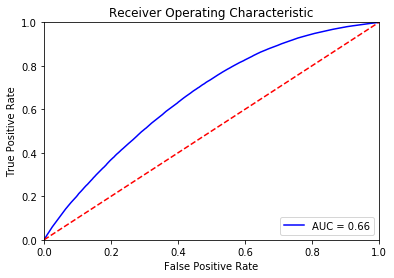

In [37]:
#plotting ROC curve!
from sklearn import metrics
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

